In [1]:
import math
import pandas as pd
import numpy as np
import copy
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, entropy_value, attribute_name, attribute_value,
                 is_final_decision, 
                 parent, 
                 is_numeric, 
                 comparison_mode, 
                 decision_value="-"):
        self.children = []
        self.entropy_value = entropy_value
        self.decision_value = decision_value
        self.attribute_name = attribute_name
        self.attribute_value = attribute_value
        self.parent = parent
        self.is_final_decision = is_final_decision
        self.is_numeric = is_numeric
        self.comparison_mode = comparison_mode
        
    def addChild(self, node):
        self.children.append(node)
        
    def getDecisionValues(self):
        if self.is_final_decision:
            return [self.decision_value]
        
        values = set()
        for child in self.children:
            child_values = child.getDecisionValues()
            values = values.union(child_values)
        return values
        
    def areAllChildrenEqual(self):
        if len(self.children) == 0:
            return True
        
        values = self.getDecisionValues()
        return len(values) == 1
    
    def areAllChildrenLeafs(self):
        leafs = True
        for child in self.children:
            leafs = leafs and child.is_final_decision
        return leafs

In [3]:
def SplitData(Raw_Data):
    data = pd.read_csv(Raw_Data,sep = ',')
    [n,m] = data.shape
    headers = list(data.columns.values)
    X = data.iloc[:,0:m-1]
    y = data.iloc[:,m-1]
    return data, X, y

In [4]:
def Entropy(data):
    Size_data = len(data)
    if Size_data == 0:
        return 0
    num_classes = [0 for i in data.iloc[:,-1].dropna().value_counts()]
    num_classes = data.iloc[:,-1].dropna().value_counts().tolist()
    num_classes = [x/Size_data for x in num_classes]
    ent = 0
    for num in num_classes:
        ent += num*math.log(num,2)
    return ent*-1

In [5]:
def Gain_Ratio(data,headers):
    List_entropy = []
    List_Sum= []
    List_split = []
    List_values_Per_Attribute = [] 
    Global_Entropy = Entropy(data)
    Numeric_Maximums = {}
    for attribute in headers[0:len(headers)-1]:
        if (np.issubdtype(data[attribute].dtype, np.number) == False):
            entropy = []
            values = []
            Split = 0
            for value in data[attribute].value_counts().index:
                # Gain Calculation
                values.append(value)
                Neg_branch = data.loc[(data[attribute] == value) & 
                                      (data[headers[len(headers)-1]] == 'No')]
                Pos_branch  = data.loc[(data[attribute] == value) & 
                                       (data[headers[len(headers)-1]] == 'Yes')]
                Total_branch = [Neg_branch,Pos_branch]
                Total_branch = pd.concat(Total_branch)
                probability_num = (len(Total_branch)/len(data))
                entropy.append(probability_num*Entropy(Total_branch))
                if probability_num != 0:
                    Split += probability_num*math.log(probability_num,2)
            Split = Split*-1
            List_values_Per_Attribute.append(list(values))
            List_split.append(Split)
            Sum_per_branch = sum(entropy)
            List_entropy.append(list(entropy))
            List_Sum.append(Sum_per_branch)
        else:
            sorted_data = data.sort_values(by=[attribute])
            # Find the threshold that gives the highest probability
            entropy = []
            values = []
            Split = 0
            for value in data[attribute].value_counts().index:
                # Gain Calculation
                values.append(value)
                Neg_branch = data.loc[(data[attribute] <= value) & 
                                      (data[headers[len(headers)-1]] == 'No')]
                Pos_branch  = data.loc[(data[attribute] > value) & 
                                       (data[headers[len(headers)-1]] == 'Yes')]
                Total_branch = [Neg_branch,Pos_branch]
                Total_branch = pd.concat(Total_branch)
                probability_num = (len(Total_branch)/len(data))
                entropy.append(probability_num*Entropy(Total_branch))
                if probability_num != 0:
                    Split += probability_num*math.log(probability_num,2)
            Split = Split*-1
            List_values_Per_Attribute.append(list(values))
            List_split.append(Split)
            if len(entropy) == 0:
                Sum_per_branch = 0
            else:
                Sum_per_branch = np.amax(entropy)
            List_Sum.append(Sum_per_branch)
            if len(entropy) == 0:
                threshold = 0
            else:
                idx = np.where(entropy == Sum_per_branch)
                threshold = sorted_data[attribute].iloc[idx[0]].iloc[0]
            #print("Threshold: " + str(threshold))
            Numeric_Maximums[attribute] = float(threshold)
            #print(Numeric_Maximums)
            
    Gain = np.subtract(Global_Entropy,List_Sum)
    for i in range(len(List_split)):
        if List_split[i] == 0:
            List_split[i] = 1
    GainRatio = np.divide(Gain,List_split)
    return GainRatio, List_values_Per_Attribute, Numeric_Maximums

In [6]:
def SplitAttributes(RemainingData, 
                    headers, 
                    parent, 
                    leading_value, 
                    comparison_mode):
    headers = list(RemainingData.columns.values)
    split_values = []
    if len(headers) == 1:
        if len(RemainingData) == 0:
            decision = "-" # Can not decide
        else:
            decision = RemainingData.mode().iloc[0, -1]
        node = Node(decision_value=decision, entropy_value=0, 
                    attribute_name="Final Decision", attribute_value=leading_value, 
                    parent=parent, is_final_decision=True, is_numeric=False,
                    comparison_mode=comparison_mode)
        parent.addChild(node)
        return None
    else:
        GainRatio, values, Numeric_Maximums = Gain_Ratio(RemainingData,headers)
        index = np.argmax(GainRatio)
        GainPos = GainRatio[index]
        Best_Attribute = headers[index]
        Best_Values = values[index]
        is_numeric = np.issubdtype(data[Best_Attribute].dtype, np.number)
        
        node = Node(entropy_value=GainPos, attribute_name=Best_Attribute, 
                    attribute_value=leading_value, parent=parent, 
                    is_final_decision=False, is_numeric=is_numeric, 
                    comparison_mode=comparison_mode)
        parent.addChild(node)
        Subs = GetSubs(RemainingData, Best_Attribute, Best_Values, 
                       is_numeric, Numeric_Maximums.get(Best_Attribute, None))
        # Numeric attributes are based on a 
        # less-than split, instead of an equality one
        if is_numeric:
            return [SplitAttributes(Subs[i]["data"], headers, 
                                    node, Numeric_Maximums[Best_Attribute], 
                                    Subs[i]["comparison"]) 
                    for i in range(len(Subs))]
        else:
            return [SplitAttributes(Subs[i]["data"], headers,
                                    node, Subs[i]["val"], None) 
                    for i in range(len(Subs))]

In [7]:
def GetSubs(data, Best_Attribute, Best_Values, is_numeric, threshold_value=None):
    data_temp = data.copy()
    dataframe_collection = {} 
    if is_numeric:
        data_less_than = data_temp[data_temp[Best_Attribute] <= threshold_value]
        data_less_than = data_less_than.drop(columns= [Best_Attribute])
        dataframe_collection[0] = {"comparison": "LessEqual", 
                                   "val": threshold_value, 
                                   "data": data_less_than}
        data_greater_than = data_temp[data_temp[Best_Attribute] > threshold_value]
        data_greater_than = data_greater_than.drop(columns= [Best_Attribute])
        dataframe_collection[1] = {"comparison": "GreaterThan",
                                   "val": threshold_value, 
                                   "data": data_greater_than}
    else:
        for i in range(len(Best_Values)):
            data_equal = data_temp[data_temp[Best_Attribute] == Best_Values[i]]
            data_equal = data_equal.drop(columns= [Best_Attribute])
            dataframe_collection[i] = {"valor ": Best_Values[i], 
                                       "datos ": data_equal}
    return dataframe_collection

In [46]:
data, X, y = SplitData("categoricos.csv")
headers = list(data.columns.values)
print(headers)

['Outlook', 'Temp', 'Humidity', 'Play Golf']


In [47]:
size = len(data)
test_size = math.floor(0.3 * size)

test_data = data.iloc[:test_size, :]
train_data = data.iloc[test_size:, :]
data_temp = train_data
print("datos de entrenamiento:")
print(train_data)

datos de entrenamiento:
     Outlook  Temp Humidity Play Golf
4      Rainy  Cool   Normal       Yes
5      Rainy  Cool     High        No
6   Overcast  Cool     High       Yes
7      Sunny   Hot   Normal        No
8      Sunny  Cool   Normal       Yes
9      Rainy  Cool   Normal       Yes
10     Sunny  Cool     High       Yes
11  Overcast   Hot     High       Yes
12  Overcast  Cool   Normal       Yes
13     Rainy   Hot     High       Yes


In [48]:
def PrintTree(root, level=0):
    if root.is_final_decision:
        if root.parent is not None and root.parent.is_numeric:
            print("{} cuando {} es {} {} desicion: {}".format("--" * level, 
                                                                 root.parent.attribute_name, 
                                                                 root.comparison_mode, 
                                                                 root.attribute_value, 
                                                                 root.decision_value))
        elif root.parent is not None:
            print("{} cuando {} es {} desicion: {}".format("--" * level, 
                                                              root.parent.attribute_name,
                                                              root.attribute_value, 
                                                              root.decision_value))
    else:
        if root.parent is not None and root.parent.is_numeric:
            print("{} cuando {} es {} {} revisa {}. Prunable: {}".format("--" * level, 
                                                                           root.parent.attribute_name, 
                                                                           root.comparison_mode, 
                                                                           root.attribute_value,
                                                                           root.attribute_name, 
                                                                           root.areAllChildrenEqual()))
        elif root.parent is not None:
            print("{} cuando {} es {} revisa {}. Prunable: {}".format("--" * level, 
                                                                        root.parent.attribute_name, 
                                                                        root.attribute_value, 
                                                                        root.attribute_name, 
                                                                        root.areAllChildrenEqual()))
    for child in root.children:
        PrintTree(child, level + 1)

In [49]:
def CompressTree(root):
    if root.areAllChildrenEqual():
        values = list(root.getDecisionValues())
        value = values[0]
        root.children = []
        root.is_final_decision = True
        root.decision_value = value
        root.entropy_value = 0
        root.attribute_name = "Final Decision"
    
    for child in root.children:
        CompressTree(child)

In [50]:
root = Node(attribute_name='-se juega-', entropy_value=0, 
            parent=None, attribute_value=None, 
            is_numeric=False, 
            is_final_decision=False, 
            comparison_mode=None)
Splitter = SplitAttributes(data_temp, headers, root, 0, None)
Splitter

print("arbol antes de la comprension")
PrintTree(root)


arbol antes de la comprension
-- cuando -se juega- es 0 revisa Outlook. Prunable: False
---- cuando Outlook es Rainy revisa Humidity. Prunable: False
------ cuando Humidity es High revisa Temp. Prunable: False
-------- cuando Temp es Hot desicion: Yes
-------- cuando Temp es Cool desicion: No
------ cuando Humidity es Normal revisa Temp. Prunable: True
-------- cuando Temp es Cool desicion: Yes
---- cuando Outlook es Overcast revisa Temp. Prunable: True
------ cuando Temp es Cool revisa Humidity. Prunable: True
-------- cuando Humidity es Normal desicion: Yes
-------- cuando Humidity es High desicion: Yes
------ cuando Temp es Hot revisa Humidity. Prunable: True
-------- cuando Humidity es High desicion: Yes
---- cuando Outlook es Sunny revisa Temp. Prunable: False
------ cuando Temp es Cool revisa Humidity. Prunable: True
-------- cuando Humidity es High desicion: Yes
-------- cuando Humidity es Normal desicion: Yes
------ cuando Temp es Hot revisa Humidity. Prunable: True
-------- cu

In [51]:
# Compress the tree to remove redundant branches
CompressTree(root)

print()
print("arbol despues de la compresion")
PrintTree(root)


arbol despues de la compresion
-- cuando -se juega- es 0 revisa Outlook. Prunable: False
---- cuando Outlook es Rainy revisa Humidity. Prunable: False
------ cuando Humidity es High revisa Temp. Prunable: False
-------- cuando Temp es Hot desicion: Yes
-------- cuando Temp es Cool desicion: No
------ cuando Humidity es Normal desicion: Yes
---- cuando Outlook es Overcast desicion: Yes
---- cuando Outlook es Sunny revisa Temp. Prunable: False
------ cuando Temp es Cool desicion: Yes
------ cuando Temp es Hot desicion: No


In [52]:
def PruneTree(root, data, confidence):
    if root.parent is None:
        for child in root.children:
            PruneTree(child, data, confidence)
        return
    
    if len(root.children) == 0:
        assert(root.is_final_decision)
        
        # Leaf node, calculate errors
        corrects = len(data[(data[data.columns[-1]] == root.decision_value)])
        errors = len(data[(data[data.columns[-1]] != root.decision_value)])
        N = errors + corrects
        if N == 0:
            N = 1
        error_rate = errors / N
        p = error_rate + confidence * math.sqrt(error_rate * (1 - error_rate) / N)
        return p
    
    total_p = 0
    for child in root.children:
        if root.is_numeric:
            if child.comparison_mode == "LessEqual":
                filtered_data = data[data[root.attribute_name] <= child.attribute_value]
            else:
                filtered_data = data[data[root.attribute_name] > child.attribute_value]
        else:
            filtered_data = data[data[root.attribute_name] == child.attribute_value]
        p = PruneTree(child, filtered_data, confidence)
        total_p = total_p + p
        
    average_p = total_p / len(root.children)
    
    # Now calculate the error if we pruned this branch
    yes = len(data[(data[data.columns[-1]] == "Yes")])
    no = len(data[(data[data.columns[-1]] == "No")])
    
    if len(data) == 0:
        return average_p
    
    decision = data.mode().iloc[0, -1]
        
    corrects = len(data[(data[data.columns[-1]] == decision)])
    errors = len(data[(data[data.columns[-1]] != decision)])
    
    N = corrects + errors
    
    if N == 0:
        N = 1
    error_rate = errors / N
    p = error_rate + confidence * math.sqrt(error_rate * (1 - error_rate) / N)

    real_p = average_p
    
    if p < average_p:
        print("Pruning branch {} < {}".format(p, average_p))
        root.children = []
        root.is_final_decision = True
        root.decision_value = decision
        root.attribute_name = "Final Decision"
        real_p = p
    else:
        print("Not pruning branch {} >= {}".format(p, average_p))
        real_p = average_p
    
    return real_p

In [53]:
print(test_data)


    Outlook Temp Humidity Play Golf
0     Rainy  Hot   Normal        No
1     Sunny  Hot     High        No
2  Overcast  Hot   Normal       Yes
3     Rainy  Hot   Normal       Yes


In [54]:
z = 1

pruned_tree = copy.deepcopy(root)
PruneTree(pruned_tree, test_data, z)
CompressTree(pruned_tree)
PrintTree(pruned_tree)

Not pruning branch 0.8535533905932737 >= 0.42677669529663687
Not pruning branch 0.0 >= 0.0
Not pruning branch 0.75 >= 0.1422588984322123
-- cuando -se juega- es 0 revisa Outlook. Prunable: False
---- cuando Outlook es Rainy revisa Humidity. Prunable: False
------ cuando Humidity es High revisa Temp. Prunable: False
-------- cuando Temp es Hot desicion: Yes
-------- cuando Temp es Cool desicion: No
------ cuando Humidity es Normal desicion: Yes
---- cuando Outlook es Overcast desicion: Yes
---- cuando Outlook es Sunny revisa Temp. Prunable: False
------ cuando Temp es Cool desicion: Yes
------ cuando Temp es Hot desicion: No


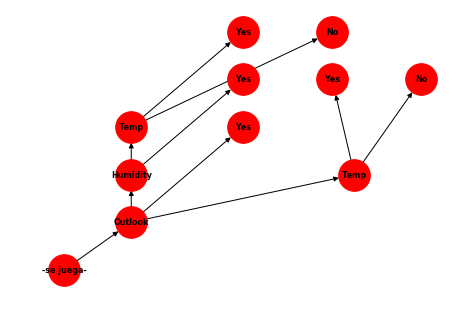

In [55]:
def ContainsPosition(positions, position):
    for pos in positions:
        if positions[pos] == position:
            return True
    return False

def CalculateNodePositions(root, positions, level=0, siblings=0):
    if len(root.children) == 0:
        tentative_pos = (5 + 3, level + 8)
        while ContainsPosition(positions, tentative_pos):
            tentative_pos = (tentative_pos[0] + 3 + 1, level + 8)
                               
        positions[root] = tentative_pos
        #print("Node at " + str(tentative_pos))
        return
    
    for i in range(len(root.children)):
        child = root.children[i]
        tentative_pos = (i * 5 + 3, level + 8)
        while ContainsPosition(positions, tentative_pos):
            tentative_pos = (tentative_pos[0] + 3 + 1, level + 8)
                               
        positions[child] = tentative_pos
        #print("Node at " + str(tentative_pos))
        CalculateNodePositions(child, positions, level + 8, len(root.children))

def ConstructGraph(root, G, labels):
    G.add_node(root)
    if root.parent is not None:
        G.add_edge(root.parent, root)
    if root.is_final_decision:
        labels[root] = "{}".format(root.decision_value)
    else:
        labels[root] = "{}".format(root.attribute_name)
    for child in root.children:
        ConstructGraph(child, G, labels)

positions = {pruned_tree: (0, 0)}
CalculateNodePositions(pruned_tree, positions)

G = nx.DiGraph()
labels = {}
ConstructGraph(pruned_tree, G, labels)
nx.draw(G, pos=positions, 
        labels=labels, 
        with_labels=True,
        font_weight='bold',
        font_size=8, 
        node_size=1000)
plt.savefig("grafico.png", format="PNG")